# Competition sulla regressione

**A cura di Rigoni Lorenzo e Moretti Riccardo**

## Librerie

In [105]:
import numpy as np
import pandas as pd
import datetime as dt

from sklearn.linear_model import LinearRegression 
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import GridSearchCV, KFold

import matplotlib.pyplot as plt

## Caricamento dataset

In [106]:
filePath = './DBs/SolarPark/train.txt'

dataframe = pd.read_csv(filePath)
dataframe.head(5)

,Time Frame,Date,Ta (C),Tm (C),I3 (W/m2),I15 (W/m2),P (kW)
0,16,3/5/12 4:55 PM,13.01,12.05,52.47,53.08,6.50
1,17,3/5/12 5:55 PM,11.81,8.50,10.41,10.95,0.01
2,18,3/5/12 6:55 PM,10.33,5.68,0.00,0.00,0.00
3,19,3/5/12 7:55 PM,9.66,4.67,0.00,0.00,0.00
4,20,3/5/12 8:55 PM,8.91,3.82,0.00,0.00,0.00


In [107]:
dataframe.info(verbose=False)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7902 entries, 0 to 7901
Columns: 7 entries, Time Frame to P (kW)
dtypes: float64(5), int64(1), object(1)
memory usage: 432.3+ KB


In [108]:
dataframe.dtypes

Time Frame      int64
Date           object
Ta (C)        float64
Tm (C)        float64
I3 (W/m2)     float64
I15 (W/m2)    float64
P (kW)        float64
dtype: object

## Preprocessing dei dati

Trasformiamo le stringhe delle date in numeri e diminuiamo la precisione dei tipi delle features

In [109]:

datetime_strings = dataframe['Date']
    
# Converte tutte le stringhe in oggetti Timestamp
datetimes = [pd.to_datetime(datetime, format='%m/%d/%y %I:%M %p') for datetime in datetime_strings]
    
# Estrae alcune informazioni dagli oggetti Timestamp
month = [datetime.month for datetime in datetimes]  # Meglio usare il mese se split temporale sequenziale
df_month = pd.DataFrame(month, columns=['Month'])
#yday = [datetime.timetuple().tm_yday for datetime in datetimes]
#df_yday = pd.DataFrame(yday, columns=['DayOfYear'])

dataframe = dataframe.merge(df_month, left_index=True, right_index=True)
#dataframe = dataframe.merge(df_yday, left_index=True, right_index=True)
dataframe = dataframe.drop(columns=['Date'])

dataframe = dataframe[['Time Frame', 'Month', 'Ta (C)', 'Tm (C)', 'I3 (W/m2)', 'I15 (W/m2)', 'P (kW)']]
dataframe

,Time Frame,Month,Ta (C),Tm (C),I3 (W/m2),I15 (W/m2),P (kW)
0,16,3,13.01,12.05,52.47,53.08,6.50
1,17,3,11.81,8.50,10.41,10.95,0.01
2,18,3,10.33,5.68,0.00,0.00,0.00
3,19,3,9.66,4.67,0.00,0.00,0.00
4,20,3,8.91,3.82,0.00,0.00,0.00
...,...,...,...,...,...,...,...
7897,2,2,0.00,0.00,0.00,0.00,0.00
7898,3,2,0.00,0.00,0.00,0.00,0.00
7899,4,2,10.25,6.83,0.00,0.00,0.00
7900,5,2,10.54,8.06,0.00,0.00,0.00


In [110]:
dataframe.dtypes

Time Frame      int64
Month           int64
Ta (C)        float64
Tm (C)        float64
I3 (W/m2)     float64
I15 (W/m2)    float64
P (kW)        float64
dtype: object

## Data exploration

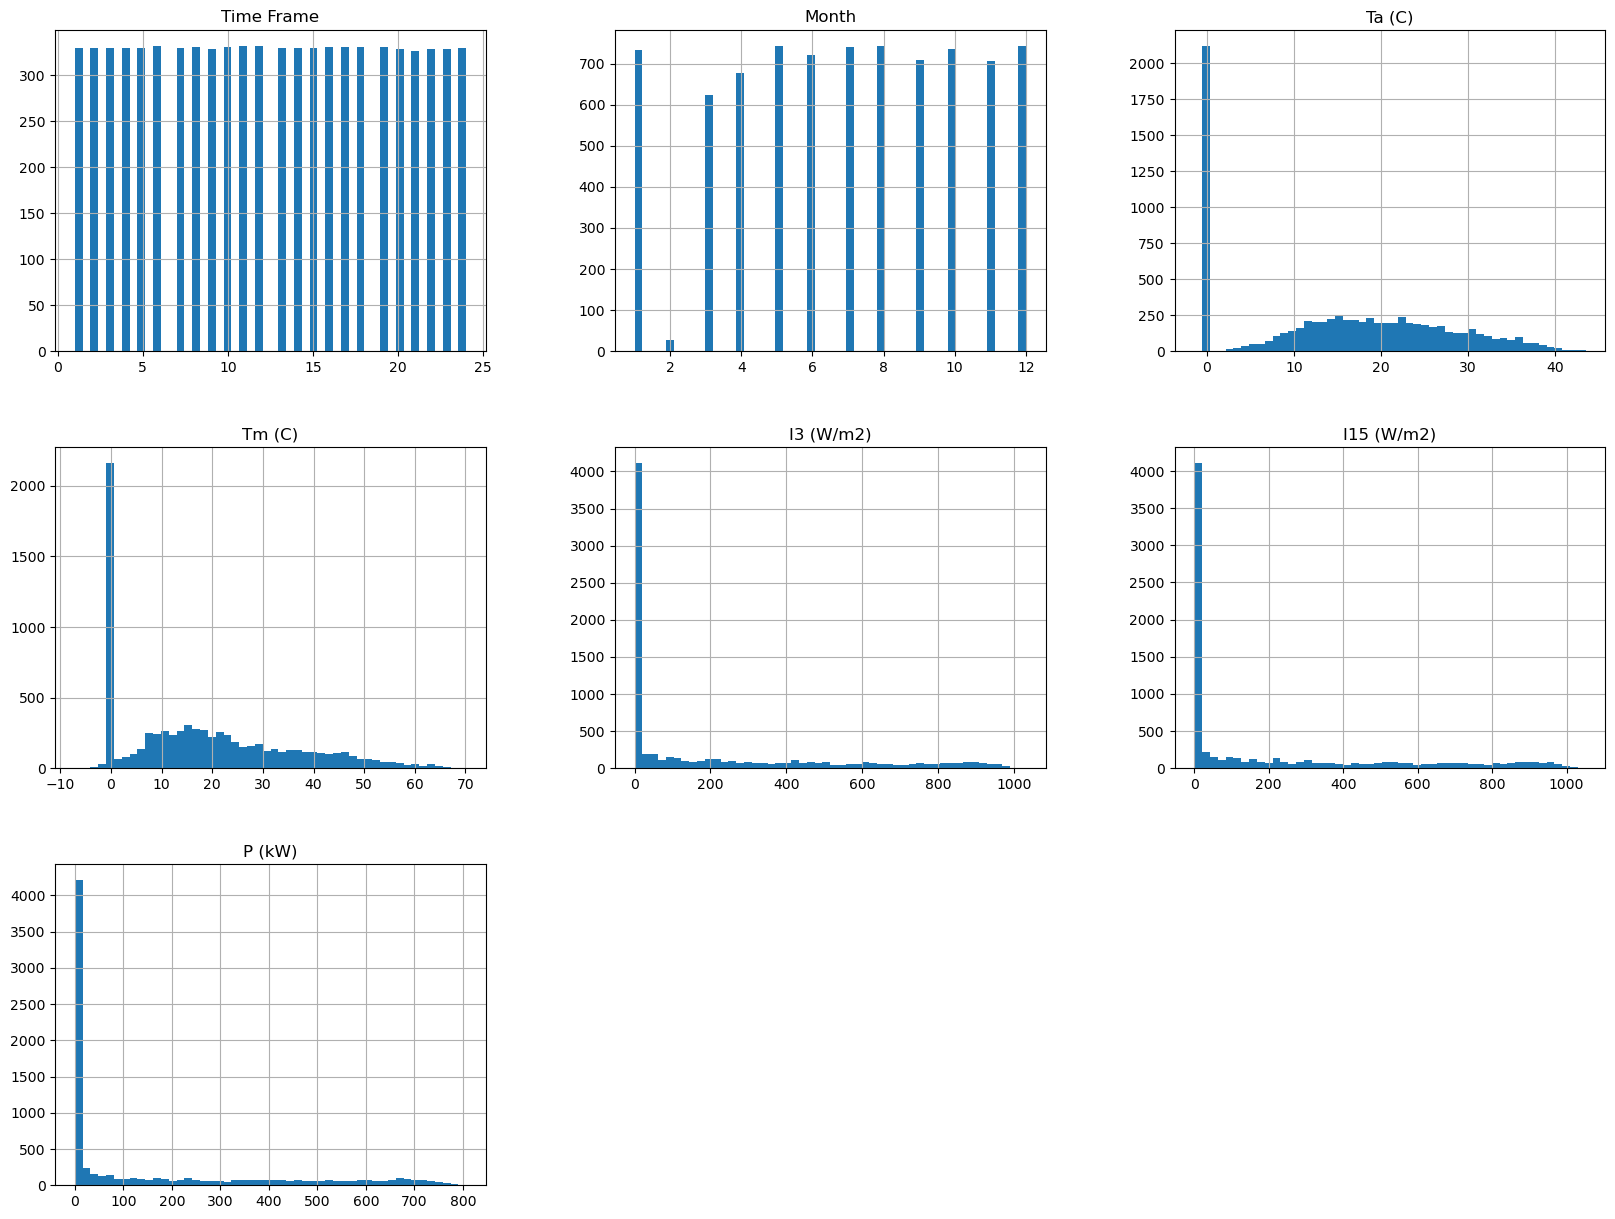

In [111]:
dataframe.hist(bins=50, figsize=(20, 15))
plt.show();

In [112]:
dataframe.isna().sum()

Time Frame    0
Month         0
Ta (C)        0
Tm (C)        0
I3 (W/m2)     0
I15 (W/m2)    0
P (kW)        0
dtype: int64

Vedendo gli istogrammi, ci sono dei casi anomali con dei picchi sullo 0 nelle varie features. Andiamo a vedere nel dettaglio i pattern di questi valori.

In [113]:
dataframe[(dataframe['P (kW)'] == 0)]

,Time Frame,Month,Ta (C),Tm (C),I3 (W/m2),I15 (W/m2),P (kW)
2,18,3,10.33,5.68,0.0,0.0,0.0
3,19,3,9.66,4.67,0.0,0.0,0.0
4,20,3,8.91,3.82,0.0,0.0,0.0
5,21,3,8.05,2.97,0.0,0.0,0.0
6,22,3,0.00,0.00,0.0,0.0,0.0
...,...,...,...,...,...,...,...
7896,1,2,0.00,0.00,0.0,0.0,0.0
7897,2,2,0.00,0.00,0.0,0.0,0.0
7898,3,2,0.00,0.00,0.0,0.0,0.0
7899,4,2,10.25,6.83,0.0,0.0,0.0


In [114]:
dataframe[(dataframe['Ta (C)'] == 0) & (dataframe['Tm (C)'] == 0)]

,Time Frame,Month,Ta (C),Tm (C),I3 (W/m2),I15 (W/m2),P (kW)
6,22,3,0.0,0.0,0.0,0.0,0.0
7,23,3,0.0,0.0,0.0,0.0,0.0
8,24,3,0.0,0.0,0.0,0.0,0.0
9,1,3,0.0,0.0,0.0,0.0,0.0
10,2,3,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...
7894,23,2,0.0,0.0,0.0,0.0,0.0
7895,24,2,0.0,0.0,0.0,0.0,0.0
7896,1,2,0.0,0.0,0.0,0.0,0.0
7897,2,2,0.0,0.0,0.0,0.0,0.0


In [115]:
dataframe[(dataframe['Time Frame'] > 21) | (dataframe['Time Frame'] < 4)]

,Time Frame,Month,Ta (C),Tm (C),I3 (W/m2),I15 (W/m2),P (kW)
6,22,3,0.0,0.0,0.0,0.0,0.0
7,23,3,0.0,0.0,0.0,0.0,0.0
8,24,3,0.0,0.0,0.0,0.0,0.0
9,1,3,0.0,0.0,0.0,0.0,0.0
10,2,3,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...
7894,23,2,0.0,0.0,0.0,0.0,0.0
7895,24,2,0.0,0.0,0.0,0.0,0.0
7896,1,2,0.0,0.0,0.0,0.0,0.0
7897,2,2,0.0,0.0,0.0,0.0,0.0


In [116]:
dataframe[(dataframe['Tm (C)'] < 0)]

,Time Frame,Month,Ta (C),Tm (C),I3 (W/m2),I15 (W/m2),P (kW)
204,4,3,4.82,-0.64,234.81,308.02,211.19
205,5,3,4.83,-0.64,454.82,538.27,406.48
206,6,3,5.34,-0.18,634.18,741.10,576.34
275,4,3,5.49,-1.56,636.50,742.56,575.18
276,5,3,5.84,-0.43,764.20,871.16,672.47
...,...,...,...,...,...,...,...
7827,4,1,3.78,-1.06,0.00,0.00,0.00
7828,5,1,3.47,-0.93,0.00,0.00,0.00
7829,6,1,3.16,-1.50,0.00,0.00,0.00
7830,7,1,3.37,-0.55,0.00,0.05,0.04


In [117]:
dataframe[(dataframe['I3 (W/m2)'] == 0)]

,Time Frame,Month,Ta (C),Tm (C),I3 (W/m2),I15 (W/m2),P (kW)
2,18,3,10.33,5.68,0.0,0.0,0.00
3,19,3,9.66,4.67,0.0,0.0,0.00
4,20,3,8.91,3.82,0.0,0.0,0.00
5,21,3,8.05,2.97,0.0,0.0,0.00
6,22,3,0.00,0.00,0.0,0.0,0.00
...,...,...,...,...,...,...,...
7897,2,2,0.00,0.00,0.0,0.0,0.00
7898,3,2,0.00,0.00,0.0,0.0,0.00
7899,4,2,10.25,6.83,0.0,0.0,0.00
7900,5,2,10.54,8.06,0.0,0.0,0.00


In [118]:
dataframe[(dataframe['I15 (W/m2)'] == 0)]

,Time Frame,Month,Ta (C),Tm (C),I3 (W/m2),I15 (W/m2),P (kW)
2,18,3,10.33,5.68,0.0,0.0,0.00
3,19,3,9.66,4.67,0.0,0.0,0.00
4,20,3,8.91,3.82,0.0,0.0,0.00
5,21,3,8.05,2.97,0.0,0.0,0.00
6,22,3,0.00,0.00,0.0,0.0,0.00
...,...,...,...,...,...,...,...
7897,2,2,0.00,0.00,0.0,0.0,0.00
7898,3,2,0.00,0.00,0.0,0.0,0.00
7899,4,2,10.25,6.83,0.0,0.0,0.00
7900,5,2,10.54,8.06,0.0,0.0,0.00


Come prima cosa, eliminiamo le righe dove tutti i sensori sono spenti, ovvero hanno valore 0.

In [119]:
dataframe = dataframe[~((dataframe['Ta (C)'] == 0) & (dataframe['Tm (C)'] == 0) & (dataframe['I3 (W/m2)'] == 0) & (dataframe['I15 (W/m2)'] == 0))]

In [120]:
dataframe.shape

(5825, 7)

In [121]:
dataframe

,Time Frame,Month,Ta (C),Tm (C),I3 (W/m2),I15 (W/m2),P (kW)
0,16,3,13.01,12.05,52.47,53.08,6.50
1,17,3,11.81,8.50,10.41,10.95,0.01
2,18,3,10.33,5.68,0.00,0.00,0.00
3,19,3,9.66,4.67,0.00,0.00,0.00
4,20,3,8.91,3.82,0.00,0.00,0.00
...,...,...,...,...,...,...,...
7891,20,2,10.20,6.78,0.00,0.00,0.00
7892,21,2,9.70,6.13,0.00,0.00,0.00
7899,4,2,10.25,6.83,0.00,0.00,0.00
7900,5,2,10.54,8.06,0.00,0.00,0.00


Ora andiamo a vedere le correlazioni tra le features e la variabile target.

In [122]:
corr_matrix = dataframe.corr(numeric_only=True)
print(corr_matrix["P (kW)"].sort_values(ascending=False))

P (kW)        1.000000
I3 (W/m2)     0.983179
I15 (W/m2)    0.983086
Tm (C)        0.652679
Ta (C)        0.427638
Month        -0.086452
Time Frame   -0.294026
Name: P (kW), dtype: float64


Possiamo notare come le features più significative siano `I3 (W/m2)` e `I15 (W/m2)` per la variabile target `P (kW)`. Dunque, proviamo a mantenere solo queste due features per la regressione

In [123]:
dataframe = dataframe.drop(columns=['Month', 'Time Frame'])

dataframe

,Ta (C),Tm (C),I3 (W/m2),I15 (W/m2),P (kW)
0,13.01,12.05,52.47,53.08,6.50
1,11.81,8.50,10.41,10.95,0.01
2,10.33,5.68,0.00,0.00,0.00
3,9.66,4.67,0.00,0.00,0.00
4,8.91,3.82,0.00,0.00,0.00
...,...,...,...,...,...
7891,10.20,6.78,0.00,0.00,0.00
7892,9.70,6.13,0.00,0.00,0.00
7899,10.25,6.83,0.00,0.00,0.00
7900,10.54,8.06,0.00,0.00,0.00


Essendoci molti valori nulli, andiamo a vedere in quanti casi con le features nulle abbiamo un valore non nullo per la variabile target.

In [124]:
dataframe[(dataframe['I3 (W/m2)'] == 0) & (dataframe['I15 (W/m2)'] == 0) & (dataframe['P (kW)'] != 0)]

,Ta (C),Tm (C),I3 (W/m2),I15 (W/m2),P (kW)
169,10.55,9.31,0.0,0.0,0.02
192,12.51,13.11,0.0,0.0,0.01
197,7.93,2.38,0.0,0.0,0.05
215,14.98,16.98,0.0,0.0,1.28
238,16.97,23.39,0.0,0.0,0.07
...,...,...,...,...,...
6954,2.16,-2.47,0.0,0.0,0.01
7303,4.52,1.55,0.0,0.0,0.01
7506,9.72,6.84,0.0,0.0,0.01
7663,5.87,0.78,0.0,0.0,0.01


In [125]:
dataframe[(dataframe['I3 (W/m2)'] == 0) & (dataframe['I15 (W/m2)'] == 0) & (dataframe['P (kW)'] != 0)]['P (kW)'].mean()

0.8854285714285712

Dunque, abbiamo che in 70 casi su 5825 con entrmbe le I = 0, la potenza è diversa da 0. Ma, in questi casi, il valore è sempre piccolo (media di circa 0.88 kW), quindi possiamo considerarlo come caso limite e cancellare queste righe.

In [126]:
#dataframe = dataframe[~((dataframe['I3 (W/m2)'] == 0) & (dataframe['I15 (W/m2)'] == 0) & (dataframe['P (kW)'] != 0))]

dataframe

,Ta (C),Tm (C),I3 (W/m2),I15 (W/m2),P (kW)
0,13.01,12.05,52.47,53.08,6.50
1,11.81,8.50,10.41,10.95,0.01
2,10.33,5.68,0.00,0.00,0.00
3,9.66,4.67,0.00,0.00,0.00
4,8.91,3.82,0.00,0.00,0.00
...,...,...,...,...,...
7891,10.20,6.78,0.00,0.00,0.00
7892,9.70,6.13,0.00,0.00,0.00
7899,10.25,6.83,0.00,0.00,0.00
7900,10.54,8.06,0.00,0.00,0.00


Infine, eliminiamo anche le righe dove tutte le colonne sono a 0.

In [ ]:
dataframe = dataframe[~((dataframe['I3 (W/m2)'] == 0) & (dataframe['I15 (W/m2)'] == 0) & (dataframe['P (kW)'] == 0))]

dataframe

,Ta (C),Tm (C),I3 (W/m2),I15 (W/m2),P (kW)
0,13.01,12.05,52.47,53.08,6.50
1,11.81,8.50,10.41,10.95,0.01
13,4.75,1.22,22.09,25.61,14.75
14,5.08,2.00,153.43,186.61,127.16
15,7.11,5.86,323.21,399.02,302.46
...,...,...,...,...,...
7885,18.49,31.56,465.00,519.28,408.38
7886,17.20,23.11,246.92,297.06,202.96
7887,15.27,14.52,56.64,95.40,49.33
7888,12.54,8.89,0.47,0.83,0.77


## Divisione dei dati

Andiamo ora a dividere le features dalla variabile target.

In [132]:
X = dataframe.values[:, :4]
y = dataframe.values[:, 4]

train_X = X[0:-1, :]
train_y = y[1:]

## Modelli di regressione

### LinearRegression

In [133]:
kf = KFold(5, shuffle=False)

In [134]:
linreg_model = Pipeline([
    ("scaler", StandardScaler()),
    ("linreg", LinearRegression())
])

linreg_grid = {
    "linreg__fit_intercept": [True, False],
    "linreg__positive": [True, False]
}

linreg_gs = GridSearchCV(linreg_model, linreg_grid, cv=kf, scoring='neg_mean_squared_error', n_jobs=-1)
linreg_gs.fit(train_X, train_y)

print("Iperparametri scelti:", linreg_gs.best_params_)

print("Training RMSE:", np.sqrt(-linreg_gs.best_score_))

Iperparametri scelti: {'linreg__fit_intercept': True, 'linreg__positive': True}
Training RMSE: 113.76645452187064


### RandomForestRegressor

In [136]:
rfr_model = Pipeline([
    ("scaler", StandardScaler()),
    ("rfr", RandomForestRegressor())
])

rfr_grid = {
    "rfr__n_estimators": range(100, 1000, 100),
    #"rfr__criterion": ['squared_error', 'absolute_error', 'friedman_mse', 'poisson'],
    "rfr__max_features": ['sqrt', 'log2'],
    "rfr__max_depth": range(1, 10)
}

rfr_gs = GridSearchCV(rfr_model, rfr_grid, cv=kf, scoring='neg_mean_squared_error', n_jobs=-1)
rfr_gs.fit(train_X, train_y)

print("Iperparametri scelti:", rfr_gs.best_params_)

print("Training RMSE:", np.sqrt(-rfr_gs.best_score_))

Iperparametri scelti: {'rfr__max_depth': 4, 'rfr__max_features': 'sqrt', 'rfr__n_estimators': 400}
Training RMSE: 114.42049492158081
